# **Name: Omkar Balekundri**
# **Final Project: News summarization using T5 Model**

In [ ]:
from datasets import load_dataset, Dataset
import pandas as pd
import re
from transformers import  T5Tokenizer, T5ForConditionalGeneration, AdamW, get_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import tensorflow as tf
import torch
from torch.utils.data import DataLoader
from rouge_score import rouge_scorer
from tqdm import tqdm


/Users/omkar/Documents/Project/NLU_project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **Loading the Data**
I have loaded the data from Huggingface datasets.
Link: https://huggingface.co/datasets/abisee/cnn_dailymail

In [ ]:
train_dataset = load_dataset("abisee/cnn_dailymail", "3.0.0", split="train") #Training dataset
valid_dataset = load_dataset("abisee/cnn_dailymail", "3.0.0", split="validation") #Validation dataset
test_dataset  = load_dataset("abisee/cnn_dailymail", "3.0.0", split="test")#Test dataset

Convert the dataset into pandas dataframe for better processing.

In [ ]:
train_df = train_dataset.to_pandas()
val_df = valid_dataset.to_pandas()
test_df = test_dataset.to_pandas()


In [ ]:
train_df.head()

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


In [ ]:
print(train_df.iloc[1]['article'])

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won't do what they're told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less likely to follow dir

# **Data Pre-Processing**
Implemented a class TextCleaner for cleaning and pre-processing the data.

In [ ]:
class TextCleaner:
    """Class responsible for cleaning, normalizing text."""

    @staticmethod
    def clean_text(text):
        """Standard cleaning """
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text)

        # Keep alphanumeric characters including symbols like $, %, &
        text = re.sub(r'[^A-Za-z0-9,.!?\'":;()\-£$€%&@ ]', '', text)

        text = text.strip()
        return text

    @staticmethod
    def normalize_text(text):
        """Lowercase"""
        return text.lower()

    @staticmethod
    def clean_dataframe(df, article_column, highlight_column):
        """For cleaning, normalization to both 'article' and 'highlights' columns."""

        df[article_column] = df[article_column].fillna("")
        df['clean_article'] = df[article_column].apply(
            lambda x: TextCleaner.normalize_text(TextCleaner.clean_text(x))
        )
        df['clean_highlight'] = df[highlight_column].apply(
            lambda x: TextCleaner.normalize_text(TextCleaner.clean_text(x))
        )

        return df

Cleaning all three datasets: Training, Validation, and Testing.

In [ ]:
train_df = TextCleaner.clean_dataframe(train_df, 'article', 'highlights')
val_df = TextCleaner.clean_dataframe(val_df, 'article', 'highlights')
test_df = TextCleaner.clean_dataframe(test_df, 'article', 'highlights')


# **Exploratory Data Analysis**
Performed EDA on the articles and higlights.

In [ ]:
print("Shape of Train dataset:",train_df.shape)
print("Shape of Validation dataset:",val_df.shape)
print("Shape of Test dataset:",test_df.shape)

Shape of Train dataset: (287113, 3)
Shape of Validation dataset: (13368, 3)
Shape of Test dataset: (11490, 3)


Finding the length of article and higlights.

In [ ]:
train_df['article_length'] = train_df['clean_article'].apply(len)
train_df['highlight_length'] = train_df['clean_highlight'].apply(len)

In [ ]:
# Function to generate and display a word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=200,
        colormap='viridis'
    ).generate(' '.join(text))

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

**Histogram plot for length distribution of Article and Highlights**

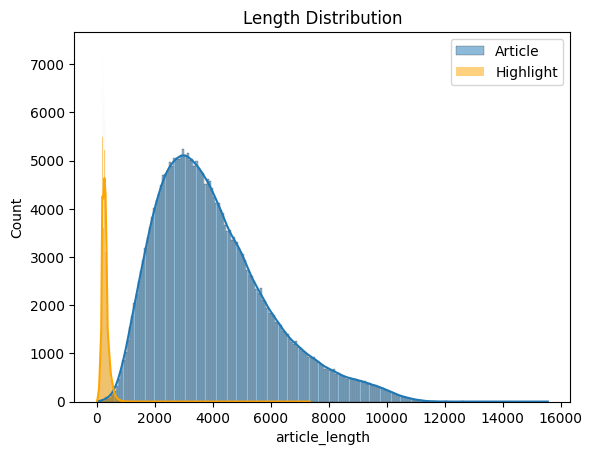

In [ ]:
# Length distributions
sns.histplot(train_df['article_length'], kde=True, label='Article')
sns.histplot(train_df['highlight_length'], kde=True, color='orange', label='Highlight')
plt.legend()
plt.title('Length Distribution')
plt.show()


**Word Cloud of Article and Highlights data**

In [ ]:
cloud_article_set = train_df['clean_article'].iloc[0:50000]
cloud_highlight_set = train_df['clean_highlight'].iloc[0:50000]

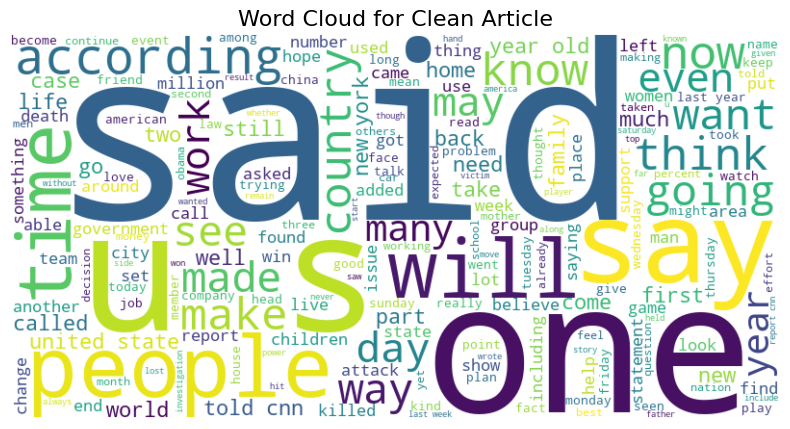

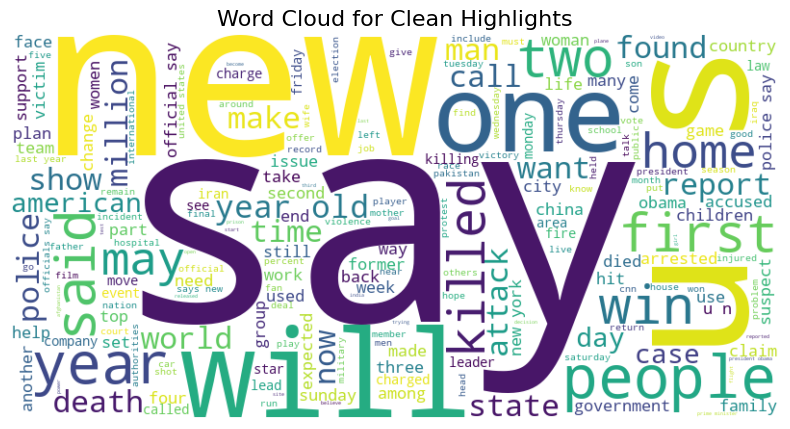

In [ ]:
# Word cloud of 'clean_article'
plot_wordcloud(cloud_article_set, 'Word Cloud for Clean Article')

# Word cloud of 'clean_highlights'
plot_wordcloud(cloud_highlight_set, 'Word Cloud for Clean Highlights')

# **Fine-tuning T5-base model**

Setup and Initialization

In [ ]:
train_df = train_df.drop(columns=['article', 'highlights'])
val_df = val_df.drop(columns=['article', 'highlights'])
test_df = test_df.drop(columns=['article', 'highlights'])

In [ ]:
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

shard_train_dataset = train_dataset.shard(num_shards=310, index=0)
shard_valid_dataset = valid_dataset.shard(num_shards=300, index=0)
shard_test_dataset = test_dataset.shard(num_shards=300, index=0)

# Print the sizes of the datasets
print(f"Original Train Dataset Size: {len(train_dataset)}")
print(f"Sharded Train Dataset Size: {len(shard_train_dataset)}")
print(f"Original Validation Dataset Size: {len(valid_dataset)}")
print(f"Sharded Validation Dataset Size: {len(shard_valid_dataset)}")
print(f"Original Test Dataset Size: {len(test_dataset)}")
print(f"Sharded Test Dataset Size: {len(shard_test_dataset)}")

Original Train Dataset Size: 287113
Sharded Train Dataset Size: 927
Original Validation Dataset Size: 13368
Sharded Validation Dataset Size: 45
Original Test Dataset Size: 11490
Sharded Test Dataset Size: 39


**Tokenization and Preprocessing**

Processes the text data for summarization using T5 tokenizer.

In [ ]:
# Load tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Preprocessing function
def preprocess_function(examples):
    inputs = [article for article in examples['clean_article']]
    targets = [summary for summary in examples['clean_highlight']]

    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")
    labels = tokenizer(targets, max_length=150, truncation=True, padding="max_length")

    # Setting labels to -100 , to ignore them in the loss computation
    for i in range(len(labels['input_ids'])):
        labels['input_ids'][i] = [label if label != tokenizer.pad_token_id else -100 for label in labels['input_ids'][i]]

    model_inputs['labels'] = labels['input_ids']
    return model_inputs

# Preprocess datasets
token_train_dataset = shard_train_dataset.map(preprocess_function, batched=True)
token_valid_dataset = shard_valid_dataset.map(preprocess_function, batched=True)
token_test_dataset = shard_test_dataset.map(preprocess_function, batched=True)

# For PyTorch
token_train_dataset.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])
token_valid_dataset.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])
token_test_dataset.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])

C:\Users\shiva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\shiva\.cache\huggingface\hub\models--t5-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
You are using the default legacy behaviou

Loading the model

In [ ]:
# Load the T5-base model
model = T5ForConditionalGeneration.from_pretrained("t5-base")

Fine-tuning

In [ ]:
# DataLoaders
train_loader = DataLoader(token_train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(token_valid_dataset, batch_size=16)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
num_training_steps = len(train_loader) * 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=500, num_training_steps=num_training_steps)

# ROUGE Scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'], use_stemmer=True)

# Training Loop
epochs = 3
for epoch in range(epochs):
    model.train()
    total_train_loss = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", leave=False):
        # Forward pass
        outputs = model(**batch)
        loss = outputs.loss
        total_train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch + 1}: Training Loss: {avg_train_loss:.4f}")

    # Validation Loop
    model.eval()
    total_val_loss = 0
    references = []
    predictions = []

    with torch.no_grad():
        # Validation Loop
        for batch in tqdm(val_loader, desc=f"Validating Epoch {epoch + 1}", leave=False):
            outputs = model.generate(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

            # Decode predictions
            preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            predictions.extend(preds)

            labels = batch['labels'].clone()
            labels[labels == -100] = tokenizer.pad_token_id

            refs = tokenizer.batch_decode(labels, skip_special_tokens=True)
            references.extend(refs)

            # Compute validation loss
            outputs = model(**batch)
            total_val_loss += outputs.loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch {epoch + 1}: Validation Loss: {avg_val_loss:.4f}")

    # ROUGE Evaluation
    rouge1, rouge2, rougeL, rougeLsum = 0, 0, 0, 0
    for ref, pred in zip(references, predictions):
        scores = scorer.score(ref, pred)
        rouge1 += scores['rouge1'].fmeasure
        rouge2 += scores['rouge2'].fmeasure
        rougeL += scores['rougeL'].fmeasure
        rougeLsum += scores['rougeLsum'].fmeasure

    # Average ROUGE scores
    rouge1 /= len(references)
    rouge2 /= len(references)
    rougeL /= len(references)
    rougeLsum /= len(references)

    print(f"Epoch {epoch + 1}: ROUGE-1: {rouge1:.4f}, ROUGE-2: {rouge2:.4f}, ROUGE-L: {rougeL:.4f}, ROUGE-Lsum: {rougeLsum:.4f}")

# Save model and tokenizer
output_dir = "./t5_finetuned"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model saved to {output_dir}")


C:\Users\shiva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Training Loss: 1.3484


Epoch 1: Validation Loss: 1.4488
Epoch 1: ROUGE-1: 0.3055, ROUGE-2: 0.1252, ROUGE-L: 0.2452, ROUGE-Lsum: 0.2452


Epoch 2: Training Loss: 1.3296


Epoch 2: Validation Loss: 1.4495
Epoch 2: ROUGE-1: 0.2976, ROUGE-2: 0.1240, ROUGE-L: 0.2446, ROUGE-Lsum: 0.2446


Epoch 3: Training Loss: 1.3087


Epoch 3: Validation Loss: 1.4523
Epoch 3: ROUGE-1: 0.2969, ROUGE-2: 0.1204, ROUGE-L: 0.2483, ROUGE-Lsum: 0.2483
Model saved to ./t5_finetuned


**Testing the fine-tuned model on test dataset.**

In [ ]:
test_loader = DataLoader(token_test_dataset, batch_size=16)

test_predictions = []
test_references = []

model.eval()

with torch.no_grad():
    total_test_loss = 0
    for batch in tqdm(test_loader, desc="Testing"):
        outputs = model.generate(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        test_predictions.extend(preds)

        labels = batch['labels'].clone()
        labels[labels == -100] = tokenizer.pad_token_id
        refs = tokenizer.batch_decode(labels, skip_special_tokens=True)
        test_references.extend(refs)

        # Compute test loss
        outputs = model(**batch)
        total_test_loss += outputs.loss.item()

# Compute average test loss
avg_test_loss = total_test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

# ROUGE Evaluation on Test Dataset
test_rouge1, test_rouge2, test_rougeL, test_rougeLsum = 0, 0, 0, 0
for ref, pred in zip(test_references, test_predictions):
    scores = scorer.score(ref, pred)
    test_rouge1 += scores['rouge1'].fmeasure
    test_rouge2 += scores['rouge2'].fmeasure
    test_rougeL += scores['rougeL'].fmeasure
    test_rougeLsum += scores['rougeLsum'].fmeasure

# Average ROUGE scores for the test set
test_rouge1 /= len(test_references)
test_rouge2 /= len(test_references)
test_rougeL /= len(test_references)
test_rougeLsum /= len(test_references)

print(f"Test ROUGE-1: {test_rouge1:.4f}, ROUGE-2: {test_rouge2:.4f}, ROUGE-L: {test_rougeL:.4f}, ROUGE-Lsum: {test_rougeLsum:.4f}")

Testing: 100%|██████████| 3/3 [00:50<00:00, 16.85s/it]

Test Loss: 1.6508
Test ROUGE-1: 0.2303, ROUGE-2: 0.0935, ROUGE-L: 0.1996, ROUGE-Lsum: 0.1996


**Using the fine-tuned model for summarizing a article**

In [ ]:
# Sample article 1
article = """
LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office chart. Details of how he'll mark his landmark birthday are under wraps. His agent and publicist had no comment on his plans. "I'll definitely have some sort of party," he said in an interview. "Hopefully none of you will be reading about it." Radcliffe's earnings from the first five Potter films have been held in a trust fund which he has not been able to touch. Despite his growing fame and riches, the actor says he is keeping his feet firmly on the ground. "People are always looking to say 'kid star goes off the rails,'" he told reporters last month. "But I try very hard not to go that way because it would be too easy for them." His latest outing as the boy wizard in "Harry Potter and the Order of the Phoenix" is breaking records on both sides of the Atlantic and he will reprise the role in the last two films. Watch I-Reporter give her review of Potter's latest » . There is life beyond Potter, however. The Londoner has filmed a TV movie called "My Boy Jack," about author Rudyard Kipling and his son, due for release later this year. He will also appear in "December Boys," an Australian film about four boys who escape an orphanage. Earlier this year, he made his stage debut playing a tortured teenager in Peter Shaffer's "Equus." Meanwhile, he is braced for even closer media scrutiny now that he's legally an adult: "I just think I'm going to be more sort of fair game," he told Reuters. E-mail to a friend . Copyright 2007 Reuters. All rights reserved.This material may not be published, broadcast, rewritten, or redistributed."""

inputs = tokenizer.encode("summarize: " + article, return_tensors="pt", max_length=512, truncation=True)
summary_ids = model.generate(inputs, max_length=150, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Print
print("Original Article:\n")
print(article)
print("\nSummary:\n")
print(summary)

Original Article:


LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won't cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don't plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don't think I'll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office c

In [ ]:
# Sample article 2
article = """
(Real Simple) -- Here are five great ways to enjoy your summer. Lazing in a hammock is one of the best ways to spend a summer evening. Best way to cut jeans into shorts -- What better way to declare the start of summer? The key to cutting off jeans is not to go too short too soon. Slip on the jeans and mark the desired length on one leg with chalk. "Take them off, fold the leg at the mark, and iron the fold," says Caroline Calvin, creative director of Levi's. "Then cut just under the crease with fabric scissors. Lay the short jean leg on top of the other side and cut to evenly match." Repeat as needed to get the length you want. Ninety-degree days? Bring 'em on! The best way to catch fireflies -- How? With womanly wiles: "Fireflies blink to attract a mate," explains naturalist Lynn Havsall, director of programs at the George B. Dorr Museum of Natural History, in Bar Harbor, Maine. "Males fly around while females sit in trees, in shrubs, or on the ground. So find a female and watch her blinking pattern. Then imitate the pattern with a pen flashlight and the males will come to you." ]A plus: The bugs move slowly, so they're easy to trap in a jar. Punch some holes in the lid and add a little grass and a piece of fruit for moisture. Admire your pretty night-lights till bedtime, then let them go. The best way to run on the beach -- Who needs a treadmill when you have miles of shoreline? Running on the beach can get you into great shape. Take it from lifeguard Benjamin Guss, 25, of Del Mar, California, who recently qualified to compete in this year's Iron Man triathlon (yes, that means swimming 2.4 miles, biking 112 miles, and then running a marathon -- consecutively) in Kailua-Kona, Hawaii. Beware, shoeless Joes. If you choose to run barefoot, keep your workouts brief at first to allow tender soles to build up calluses. "You can get blisters, even burns, from hot, soft sand," says Guss. "I like to run barefoot, but for more than a couple miles, I wear shoes." Know your sand. "In soft sand, one mile is like two," says Guss. You may work foot and leg muscles you don't always use, so start slowly. And hard sand can be as tough on your legs as the road, so wear running sneakers. Pick the right time to run. "My favorite time is in the evening," says Guss. "The wind dies down, and the sand isn't that hot." To work harder, fill small bags with sand to use as hand weights. The best way to get in and out of a hammock -- Everyone looks good lazing in a hammock -- it's getting in and out that's tricky. To make it less so, try these tips from Penny Waugh, a buyer for http://www.hammocks.com/. • Position your backside toward the hammock's center and tilt back until you reach a 45-degree angle, with the hammock parallel to your rear. • Gently sit back into the hammock and let it level out. • Swing your legs up and stretch them out. • Lie back. Loll. Sigh contentedly. For a graceful exit, sit upright and swing your legs off, anchoring your feet on the ground. Then push with your behind, gathering momentum to stand. "It's tricky, since there's nothing to hold on to," says Waugh. "But it's good for the glutes." The best way to tie espadrilles -- Apply this lace-up logic from Meghan Cleary, author of "The Perfect Fit: What Your Shoes Say About You." • Slide your foot fully into the shoe and plant it firmly on the floor. • Cross and tie the laces once behind the ankle, then bring them forward, cross and tie again, and continue up the leg, depending on how long the laces are. The calf is the maximum height -- any higher and you'll look like a gladiator. • Each time you cross and tie, secure the laces slightly tighter than is comfortable, since they will loosen a bit when you walk. Just don't cut off your circulation. • For a streamlined leg, make the final tie in the back. Create a more whimsical look by putting the final tie in front with a small bow. E-mail to a friend . Get a FREE TRIAL issue of Real Simple - CLICK HERE ! Copyright 2007 Time Inc. All rights reserved."""

inputs = tokenizer.encode("summarize: " + article, return_tensors="pt", max_length=512, truncation=True)
summary_ids = model.generate(inputs, max_length=150, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Print
print("Original Article:\n")
print(article)
print("\nSummary:\n")
print(summary)

Original Article:


(Real Simple) -- Here are five great ways to enjoy your summer. Lazing in a hammock is one of the best ways to spend a summer evening. Best way to cut jeans into shorts -- What better way to declare the start of summer? The key to cutting off jeans is not to go too short too soon. Slip on the jeans and mark the desired length on one leg with chalk. "Take them off, fold the leg at the mark, and iron the fold," says Caroline Calvin, creative director of Levi's. "Then cut just under the crease with fabric scissors. Lay the short jean leg on top of the other side and cut to evenly match." Repeat as needed to get the length you want. Ninety-degree days? Bring 'em on! The best way to catch fireflies -- How? With womanly wiles: "Fireflies blink to attract a mate," explains naturalist Lynn Havsall, director of programs at the George B. Dorr Museum of Natural History, in Bar Harbor, Maine. "Males fly around while females sit in trees, in shrubs, or on the ground. So find a f

**Reference:** I refered github repository(https://github.com/shivaniNK8/News-Article-Text-Summarizer-Transformer) for building this project. I used this repository for understanding the process of fine-tuning a model for summarization.